<a href="https://colab.research.google.com/github/danisswift/Major_Project/blob/dev/Test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lucasnfe/adl-piano-midi.git

Cloning into 'adl-piano-midi'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 61 (delta 26), reused 43 (delta 11), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [ ]:
!unzip /content/adl-piano-midi/midi/adl-piano-midi.zip

Streaming output truncated to the last 5000 lines.
   creating: adl-piano-midi/Classical/Icelandic Classical/Ólafur Arnalds/
  inflating: adl-piano-midi/Classical/Icelandic Classical/Ólafur Arnalds/0040.mid  
   creating: adl-piano-midi/Classical/Classical Era/
   creating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Sonatina-1-1.mid  
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Sonatina-1.mid  
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Andante in B Flat.mid  
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Allegro.mid  
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Sonatina-1-2.mid  
  inflating: adl-piano-midi/Classical/Classical Era/Muzio Clementi/Sonatine no1.mid  
   creating: adl-piano-midi/Classical/Classical Era/Johann Baptist Wanhal/
  inflating: adl-piano-midi/Classical/Classical Era/Johann Baptist Wanhal/Rondo.m

In [ ]:
import glob
import music21
import pathlib

In [ ]:
import numpy
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Prepare the data and parse it into a Music21 notes array

In [ ]:
#data_dir = pathlib.Path('data/maestro-v2.0.0')
#if not data_dir.exists():
#  tf.keras.utils.get_file(
#      'maestro-v2.0.0-midi.zip',
#      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
#      extract=True,
#      cache_dir='.', cache_subdir='data',
#  )

In [ ]:
notes = []
for file in glob.glob("/content/adl-piano-midi/Folk/**/**/*.mid"): 
  #print(file)
  midi = music21.converter.parse(file)
  print("Parsing %s" % file)
  notes_to_parse = None
  try:
    s2 = music21.instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse() 
              
  except: 
    notes_to_parse = midi.flat.notes
    
  for element in notes_to_parse:
    if isinstance(element, music21.note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, music21.chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
print(len(notes))

Parsing /content/adl-piano-midi/Folk/British Folk/Bill Fay/War Machine.mid
Parsing /content/adl-piano-midi/Folk/British Folk/Claire Hamill/Beauty Of England.mid
Parsing /content/adl-piano-midi/Folk/Folk/Tish Hinojosa/Mountain Lullabye.mid
Parsing /content/adl-piano-midi/Folk/Folk/Tish Hinojosa/Love Of Mine (Album Version).mid
Parsing /content/adl-piano-midi/Folk/Folk/Mindy Smith/Raggedy Ann.mid
Parsing /content/adl-piano-midi/Folk/Folk/Mindy Smith/Away In a Manger.mid
Parsing /content/adl-piano-midi/Folk/Folk/Victoria Williams/Century Plant (LP Version).mid
Parsing /content/adl-piano-midi/Folk/Folk/The Roches/Weeded Out.mid
Parsing /content/adl-piano-midi/Folk/Folk/The Roches/Losing True (Album Version).mid
Parsing /content/adl-piano-midi/Folk/Folk/The Roches/Do You Hear What I Hear.mid
Parsing /content/adl-piano-midi/Folk/Folk/The Roches/It Came Upon A Midnight Clear.mid
Parsing /content/adl-piano-midi/Folk/Folk/Jennifer Warnes/Right Time Of The Night.mid
Parsing /content/adl-piano-mi

In [ ]:
import pickle

In [ ]:
with open('/content/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

In [ ]:
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

Create a mapping function to map the notes to integer-based numerical data

In [ ]:
n_vocab = len(set(notes))
sequence_length = 50

# get all pitch names
pitchnames = sorted(set(item for item in notes))

  # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)

network_output = np_utils.to_categorical(network_output)

Design the model architecture for an LSTM

In [ ]:
model = Sequential()
model.add(LSTM(128,input_shape=(network_input.shape[1], network_input.shape[2]), #512
               return_sequences=True))

model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True)) #512
model.add(Dropout(0.3))
model.add(LSTM(128))#512
model.add(Dense(128))#256
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
filepath = 'weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5'
checkpoint = ModelCheckpoint(
filepath,
monitor='loss',
verbose=0,
save_best_only=True,
mode='min'
)
callbacks_list = [checkpoint]

Train the model using Keras and the data we prepared earlier

In [ ]:
model.fit(network_input, network_output, epochs=50, batch_size=99, callbacks=callbacks_list)

Epoch 1/50
623/623 [==============================] - 300s 472ms/step - loss: 4.5521
Epoch 2/50
623/623 [==============================] - 286s 460ms/step - loss: 4.4230
Epoch 3/50
623/623 [==============================] - 270s 433ms/step - loss: 4.3765
Epoch 4/50
623/623 [==============================] - 270s 433ms/step - loss: 4.2985
Epoch 5/50
623/623 [==============================] - 268s 430ms/step - loss: 4.2015
Epoch 6/50
623/623 [==============================] - 268s 430ms/step - loss: 4.1054
Epoch 7/50
623/623 [==============================] - 267s 429ms/step - loss: 4.0233
Epoch 8/50
623/623 [==============================] - 268s 431ms/step - loss: 3.9281
Epoch 9/50
623/623 [==============================] - 269s 432ms/step - loss: 3.8449
Epoch 10/50
623/623 [==============================] - 269s 432ms/step - loss: 3.7581
Epoch 11/50
623/623 [==============================] - 271s 434ms/step - loss: 3.6743
Epoch 12/50
623/623 [==============================] - 269s 432

In [ ]:
import matplotlib.pyplot as plt


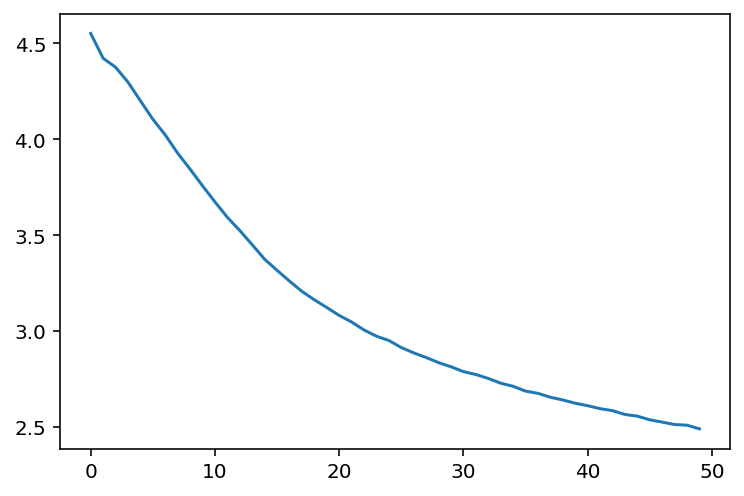

In [ ]:
plt.plot(model.history.epoch, model.history.history['loss'], label='total loss')
plt.show()

In [ ]:
from google.colab import files

In [ ]:
!mkdir -p models

In [ ]:
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1/assets


INFO:tensorflow:Assets written to: models/model_1/assets


In [ ]:
!zip -r /content/models/model_1.zip /content/models/model_1

  adding: content/models/model_1/ (stored 0%)
  adding: content/models/model_1/saved_model.pb (deflated 91%)
  adding: content/models/model_1/keras_metadata.pb (deflated 92%)
  adding: content/models/model_1/variables/ (stored 0%)
  adding: content/models/model_1/variables/variables.index (deflated 67%)
  adding: content/models/model_1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/model_1/assets/ (stored 0%)


In [ ]:
with open('/content/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

Use the model to generate new notes

At the minute, the starting sequence is random, but this will be changed to be a custom input from the user

In [ ]:
# pick a random sequence from the input as a starting point for the prediction
start = numpy.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input[start]
prediction_output = []

# generate 500 notes
for note_index in range(500):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern = numpy.append(pattern, index)
    #print(pattern)
    pattern = pattern[1:len(pattern)]

Mapping function to decode the result produced by the model back to music notes

In [ ]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = music21.instrument.AcousticGuitar()
            notes.append(new_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.AcousticGuitar()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
midi_stream = music21.stream.Stream(output_notes)

midi_stream.write('midi', fp='output20.mid')

'output20.mid'

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 1.6 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=05eecc56ce6bf1e3e581bfc339a87ca308b556e1a5aa2315393a3d7541176550
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 42 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
import pretty_midi
midi_stream.write('midi', fp='output20.mid')
pm = pretty_midi.PrettyMIDI('output20.mid')

In [ ]:
from IPython import display
# Sampling rate for audio playback
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=150):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

Play the produced music

In [ ]:
display_audio(pm)

In [ ]:
!pip install note_seq

In [ ]:
import note_seq
from note_seq.protobuf import music_pb2
noteseq = note_seq.midi_io.midi_file_to_note_sequence('output20.mid')
note_seq.plot_sequence(noteseq)